# House Price: Advance Regression Techniques

Source Link: https://www.kaggle.com/apapiu/regularized-linear-models

In [152]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from scipy.stats import skew
from scipy.stats.stats import pearsonr 


sample_submission = pd.DataFrame(pd.read_csv('sample_submission.csv'))
test_df =  pd.DataFrame(pd.read_csv('test.csv'))
train_df =  pd.DataFrame(pd.read_csv('train.csv'))

combine = [train_df, test_df]

In [153]:
%config InlineBackend.figure_format = 'retina' #set 'png' here when working on notbekoom

%matplotlib inline

In [154]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

train.shape, test.shape

((1460, 81), (1459, 80))

In [155]:
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [156]:
all_data = pd.concat((train.loc[:,'MSSubClass':'SaleCondition'],
                      test.loc[:,'MSSubClass':'SaleCondition']))

#### Data Processing

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x103069cf8>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x126338908>]], dtype=object)

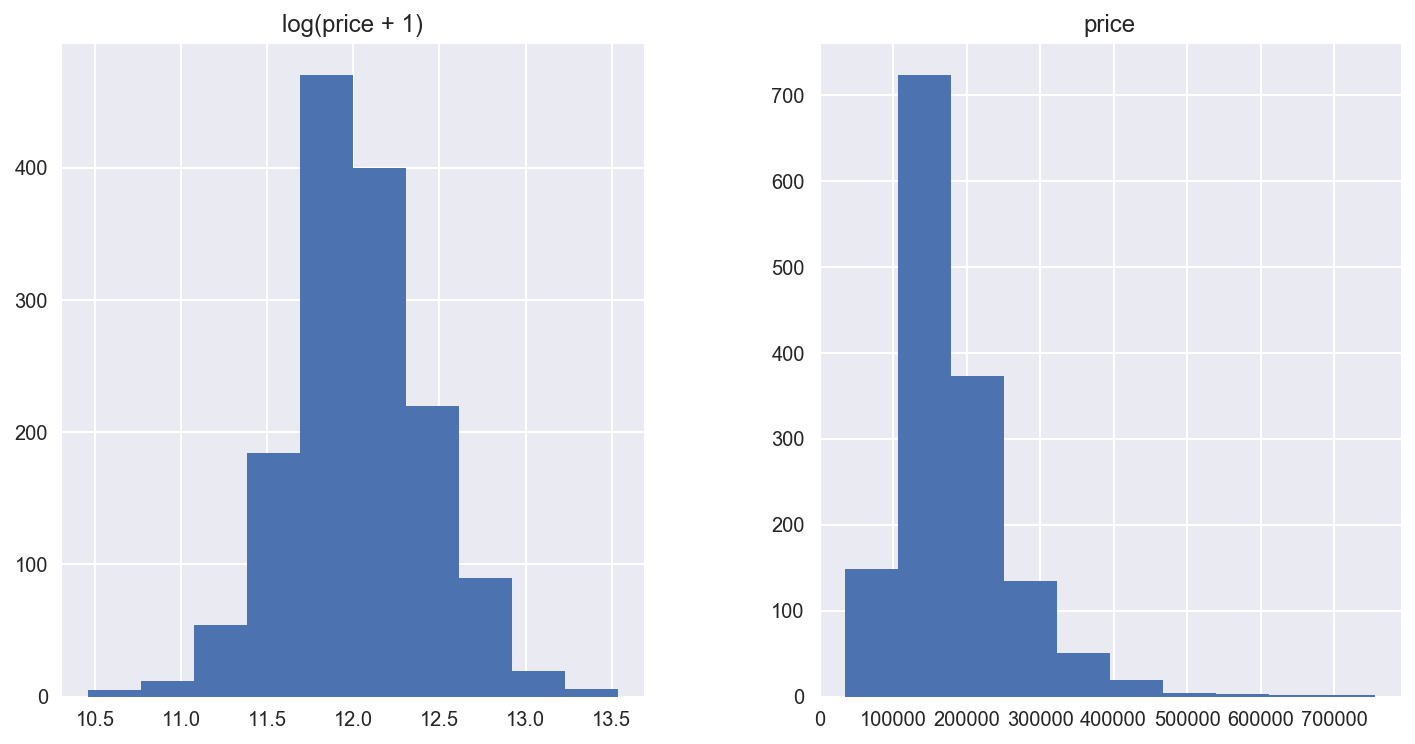

In [157]:
''' Code to manipulate the figsize notebook wide'''
matplotlib.rcParams['figure.figsize'] = (12,6.0)

'''How to create a DataFrame: Memorize it'''
prices = pd.DataFrame({"price":train['SalePrice']\
                      ,'log(price + 1)':np.log1p(train['SalePrice'])})
prices.hist()

In [158]:
train.SalePrice.head()

0    208500
1    181500
2    223500
3    140000
4    250000
Name: SalePrice, dtype: int64

In [159]:
train.SalePrice = np.log1p(train.SalePrice)
train.SalePrice.head()

0    12.247699
1    12.109016
2    12.317171
3    11.849405
4    12.429220
Name: SalePrice, dtype: float64

In [160]:
#log the transfrom skewed numeric feature
numeric_feats = all_data.dtypes[all_data.dtypes != 'object'].index


skewed_feats = train[numeric_feats].apply(lambda x: skew(x.dropna()))

# Compute Skewness, 

skewed_feats = skewed_feats[skewed_feats > 0.75]
skewed_feats = skewed_feats.index

all_data[skewed_feats] = np.log1p(all_data[skewed_feats])

In [161]:
all_data.head()

,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,4.110874,RL,4.189655,9.042040,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2008,WD,Normal
1,3.044522,RL,4.394449,9.169623,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,5,2007,WD,Normal
2,4.110874,RL,4.234107,9.328212,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0.0,0.0,NaN,NaN,NaN,0.0,9,2008,WD,Normal
3,4.262680,RL,4.110874,9.164401,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0.0,0.0,NaN,NaN,NaN,0.0,2,2006,WD,Abnorml
4,4.110874,RL,4.442651,9.565284,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0.0,0.0,NaN,NaN,NaN,0.0,12,2008,WD,Normal


In [162]:
all_data = pd.get_dummies(all_data)

In [163]:
#Filling NA's with the mean of the columns:
all_data = all_data.fillna(all_data.mean())

In [164]:
# Creating Matrices for Sklearn:
# The X_train and X_test where statement is using the orginal tables index to selcet the appopriate row again
X_train = all_data[:train.shape[0]]
X_test = all_data[train.shape[0]:]
y = train.SalePrice

X_train.shape, X_test.shape, y.shape

((1460, 288), (1459, 288), (1460,))

#### Model

In [165]:
from sklearn.linear_model import Ridge, RidgeCV,ElasticNet, LassoCV, LassoLarsCV
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, X_train, y, scoring='neg_mean_squared_error', cv=5))
    return(rmse)

In [166]:
model_ridge = Ridge()

In [167]:
alphas = [0.05,0.1,0.3,1,3,5,10,15,30,50,75]
'''This is a innovative approach using the for loop on running a custome function a list'''
cv_ridge = [rmse_cv(Ridge(alpha=alpha)).mean() for alpha in alphas]

In [168]:
model_ridge = Ridge()

Sourced: The main tuning parameter for the Ridge model is alpha - a regularization parameter that measures how flexible our model is. The higher the regularization the less prone our model will be to overfit. However it will also lose flexibility and might not capture all of the signal in the data.

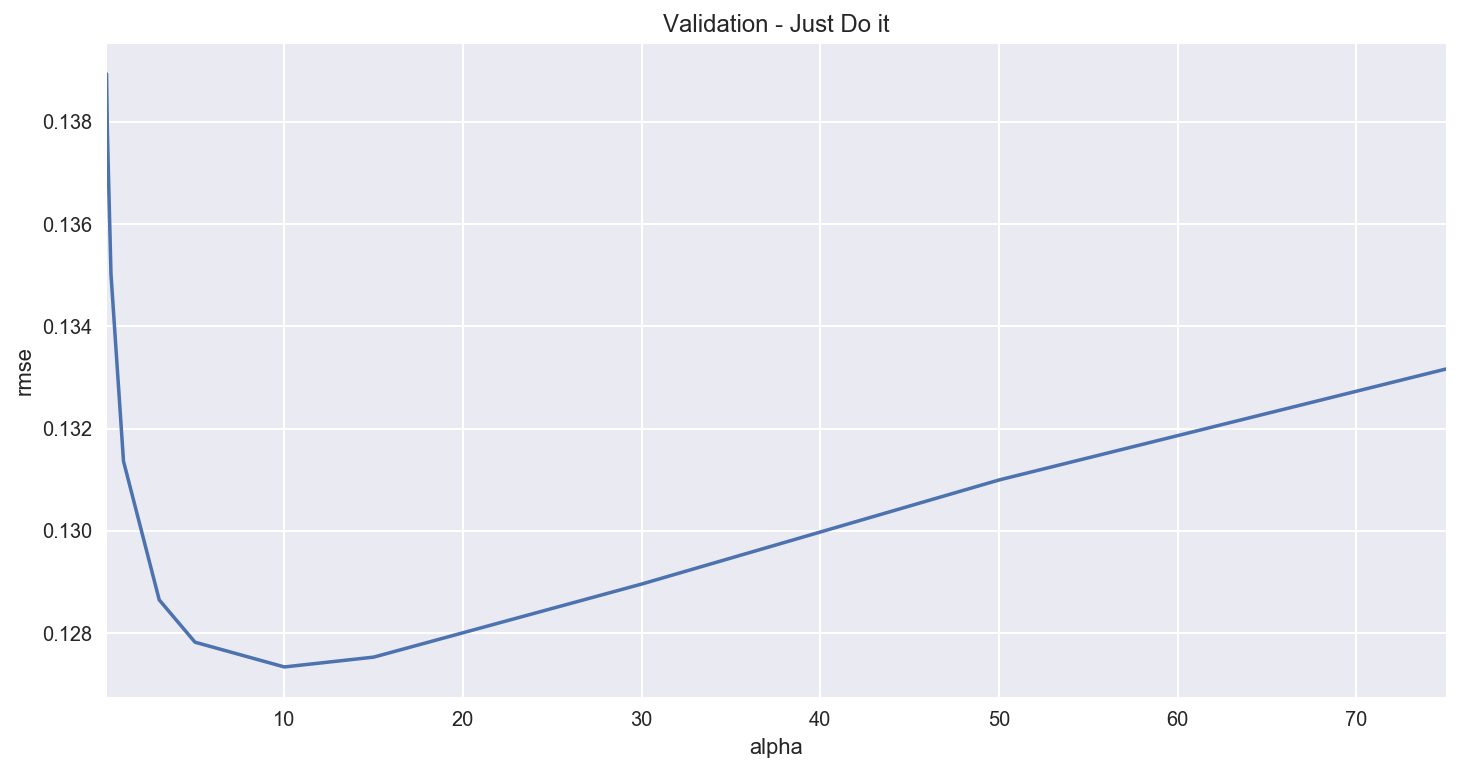

In [169]:
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot(title = 'Validation - Just Do it')
plt.xlabel('alpha')
plt.ylabel('rmse')

Note the U-ish shaped curve above. When alpha is too large the regularization is too strong and the model cannot capture all the complexities in the data. If however we let the model be too flexible (alpha small) the model begins to overfit. A value of alpha = 10 is about right based on the plot above.

In [170]:
cv_ridge.min()

0.12733734668670776

In [171]:
model_lasso = LassoCV(alphas = [1,0.1,0.001,0.0005]).fit(X_train,y)

In [172]:
rmse_cv(model_lasso).mean()

0.12314421090977432

In [173]:
coef = pd.Series(model_lasso.coef_, index = X_train.columns)
coef.head()

MSSubClass    -0.007480
LotFrontage    0.000000
LotArea        0.071826
OverallQual    0.053160
OverallCond    0.043027
dtype: float64

In [174]:
''' The string / sum function on the coeficition was smart'''
print('Lasso picked ' + str(sum(coef != 0)) + ' variables and elimated the other '\
+ str(sum(coef == 0 )) + ' variables')

Lasso picked 110 variables and elimated the other 178 variables


Good job Lasso. One thing to note here however is that the features selected are not necessarily the "correct" ones - especially since there are a lot of **collinear features** in this dataset. One idea to try here is run Lasso a few times on boostrapped samples and see how stable the feature selection is.

We can also take a look directly at what the most important coefficients are:

In [175]:
'''The head and tail functions pull the stronger positively and negatively correlated values'''

imp_coef = pd.concat([coef.sort_values().head(10), coef.sort_values().tail(10)])
imp_coef

RoofMatl_ClyTile        -0.704161
MSZoning_C (all)        -0.292023
Condition2_PosN         -0.190552
Neighborhood_Edwards    -0.052560
SaleCondition_Abnorml   -0.047116
MSZoning_RM             -0.037698
CentralAir_N            -0.035440
GarageCond_Fa           -0.031688
LandContour_Bnk         -0.030934
SaleType_WD             -0.030656
OverallQual              0.053160
KitchenQual_Ex           0.063709
Exterior1st_BrkFace      0.070464
Neighborhood_NridgHt     0.071620
LotArea                  0.071826
Functional_Typ           0.072597
Neighborhood_NoRidge     0.085717
Neighborhood_Crawfor     0.105138
Neighborhood_StoneBr     0.112493
GrLivArea                0.400009
dtype: float64

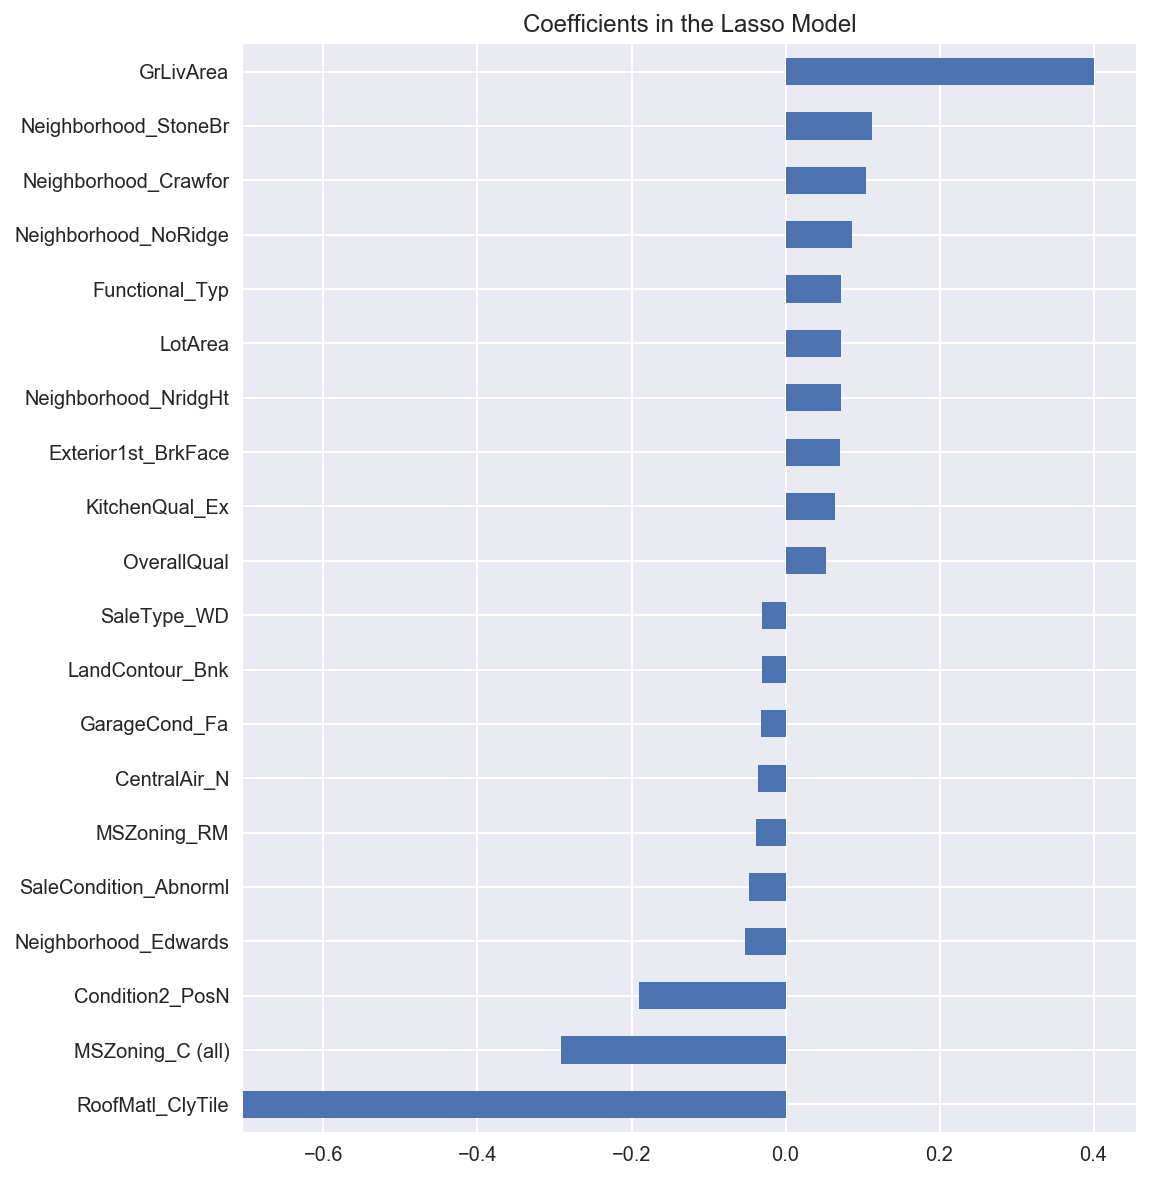

In [176]:
# For some reason the figure setting plot, plotting the barh correctly
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)

#Plotting the most important via horizonatal bar graph is bright
imp_coef.plot(kind='barh')
plt.title('Coefficients in the Lasso Model')

The most important positive feature is GrLivArea - the above ground area by area square feet. This definitely sense. Then a few other location and quality features contributed positively. Some of the negative features make less sense and would be worth looking into more - it seems like they might come from unbalanced categorical variables.

Also note that unlike the feature importance you'd get from a random forest these are actual coefficients in your model - so you can say precisely why the predicted price is what it is. The only issue here is that we log_transformed both the target and the numeric features so the actual magnitudes are a bit hard to interpret.

#### Residuals

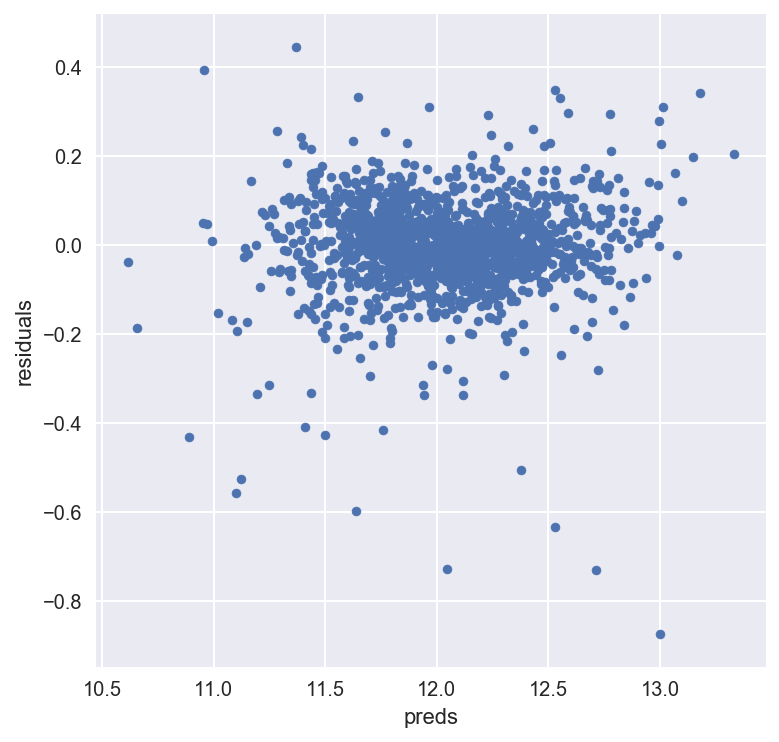

In [177]:
matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

preds = pd.DataFrame({'preds': model_lasso.predict(X_train), \
                     'true': y})
preds['residuals'] = preds['true'] - preds['preds']
preds.plot(x = 'preds', y = 'residuals', kind = 'scatter')

The residual plot looks pretty good.To wrap it up let's predict on the test set and submit on the leaderboard:

#### Adding an xgboost model:

In [178]:
import xgboost as xgb

In [179]:
dtrain = xgb.DMatrix(X_train, label = y)
dtest = xgb.DMatrix(X_test)

params = {'max_depth':2, 'eta':0.1}
model = xgb.cv(params, dtrain, num_boost_round = 500,\
early_stopping_rounds = 100)

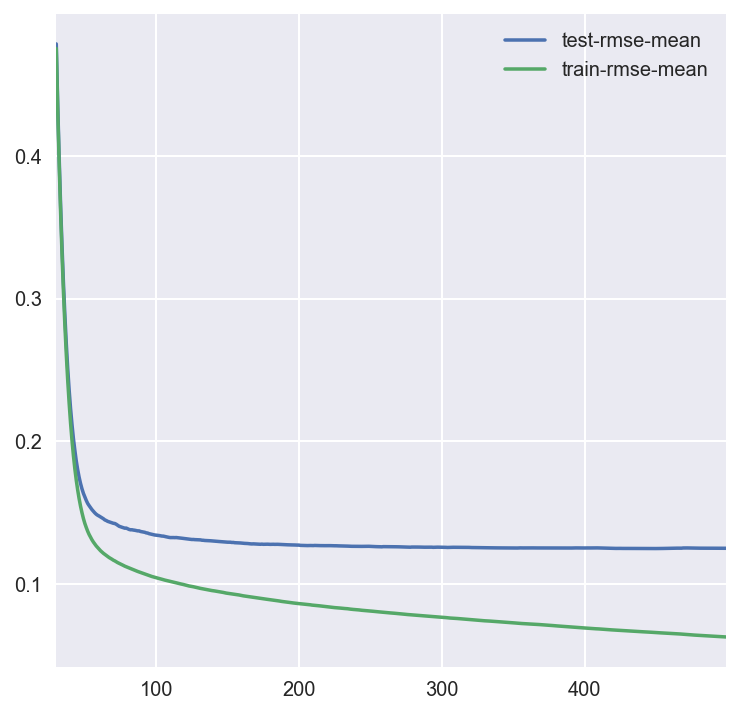

In [180]:
model.loc[30:,["test-rmse-mean", "train-rmse-mean"]].plot()

In [181]:
model_xgb = xgb.XGBRegressor(n_estimators=360, max_depth=2, \
                             learning_rate =0.1)
model_xgb.fit(X_train, y)

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=2,
       min_child_weight=1, missing=None, n_estimators=360, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [182]:
xgb_preds = np.expm1(model_xgb.predict(X_test))
lasso_preds = np.expm1(model_lasso.predict(X_test))

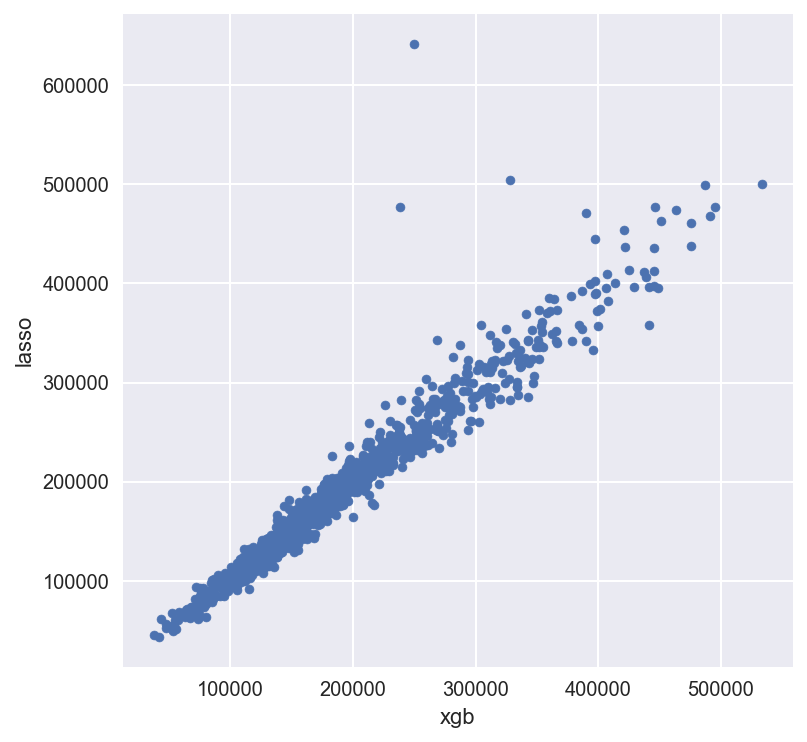

In [183]:
predictions = pd.DataFrame({'xgb':xgb_preds, 'lasso':lasso_preds})
predictions.plot(x='xgb', y='lasso',kind='scatter')

In [184]:
preds = 0.7*lasso_preds + 0.3*xgb_preds

### Exporting Result to CSV

In [185]:
solution = pd.DataFrame({"id":test_df.Id, "SalePrice":preds})
solution.head()

,SalePrice,id
0,120129.316383,1461
1,153008.785406,1462
2,181999.667866,1463
3,195952.284998,1464
4,197477.703212,1465


In [186]:

solution.to_csv('personal_submssion (Lasso + XGB Boost).csv', index = False)

Result: Positon 501 with a score of 0.12087

### Keras

In [188]:
from keras.layers import Dense
from keras.models import Sequential
from keras.regularizers import l1 # An L and one
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

In [189]:
X_train = StandardScaler().fit_transform(X_train)

In [190]:
X_train, X_test, y_train, y_test = train_test_split(X_train, y, random_state=3)

In [191]:
X_train.shape

(1095, 288)

In [192]:
X_train

array([[ 1.00573733,  0.68066137, -0.46001991, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184,  0.60296111,  0.03113183, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [-1.12520184, -0.02865265, -0.74027492, ..., -0.11785113,
         0.4676514 , -0.30599503],
       ..., 
       [ 0.16426234, -0.87075036, -0.81954431, ..., -0.11785113,
        -2.13834494, -0.30599503],
       [ 0.92361154, -0.30038284, -0.44275864, ..., -0.11785113,
         0.4676514 , -0.30599503],
       [ 0.83656519,  1.98505948,  0.46455838, ..., -0.11785113,
         0.4676514 , -0.30599503]])

In [198]:
model = Sequential \()

model.add(Dense(1, input_dim = X_train.shape[1], W_regularizer = l1 (0.001)))

model.compile(loss ='mse', optimizer='adam')

SyntaxError: unexpected character after line continuation character (<ipython-input-198-76480ba6988c>, line 1)

In [199]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_5 (Dense)              (None, 1)                 289       
Total params: 289.0
Trainable params: 289
Non-trainable params: 0.0
_________________________________________________________________


In [201]:
hist = model.fit(X_train, y_train, validation_data = (X_test, y_test))

Train on 1095 samples, validate on 365 samples
Epoch 1/10
1095/1095 [==============================] - 0s - loss: 120.8305 - val_loss: 186.0231
Epoch 2/10
1095/1095 [==============================] - 0s - loss: 119.7282 - val_loss: 188.8114
Epoch 3/10
1095/1095 [==============================] - 0s - loss: 118.7078 - val_loss: 191.8257
Epoch 4/10
1095/1095 [==============================] - 0s - loss: 117.6767 - val_loss: 194.6611
Epoch 5/10
1095/1095 [==============================] - 0s - loss: 116.6443 - val_loss: 197.7378

In [202]:
result = pd.Series(model.predict(X_train)[:,0])

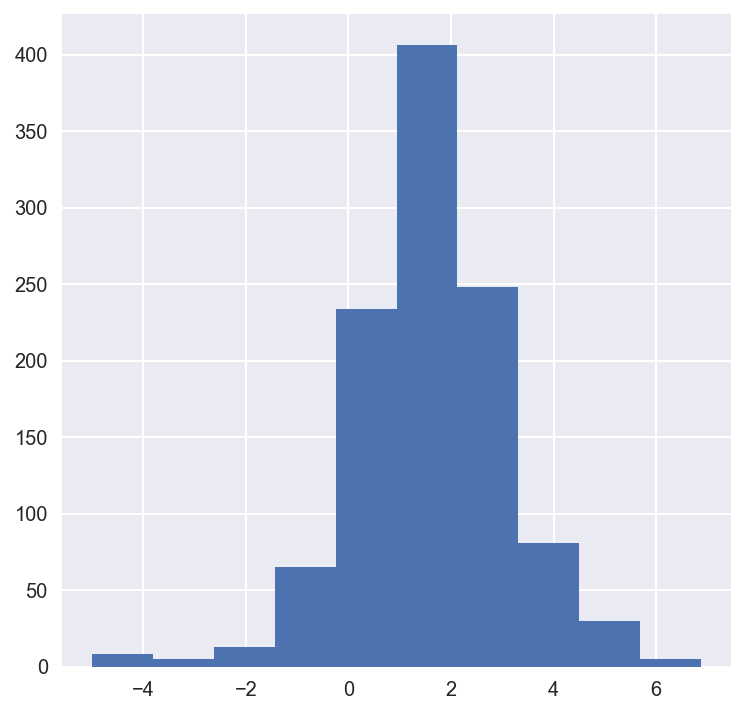

In [203]:
result.hist()